### Tabular DynaQ for the Simple Maze problem in figures 8.2 and 8.3

Start by creating the simple maze, grid world, as illustrated in figures 8.2 and 8.3. Two function are used, one to tell us if a state is valid within the maze and the other is used to take action within the maze (environment), this function returns the new state and immediate reward.

In [1]:
import numpy as np

# create a grid world, tell us if this state exists in this world
def gridworld(s):
    nw = 6
    mw = 9
    world = np.zeros((nw+2,mw+2), dtype = bool)
    world[1:(nw+1),1:(mw+1)] = True
    world[2:5,3] = False
    world[5,6] = False
    world[1:4,8] = False
    return world[s[0],s[1]]
# the environment:
def takeaction(s, a):
    step = np.array([[-1,0],[1,0],[0,-1],[0,1]])
    snew = s + step[a]
    r = 0.0
    if gridworld(snew) == True:
        sterminal = np.array([1,9]) # the goal state
        if np.all(snew == sterminal):
            r = 1.0
    else:
        snew = s # stay in same location
    return snew, r

The policy uses in the usual $\epsilon$-greedy function, here we would like to break ties randomly:

In [2]:
# a random tie-breaking argmax (code "found" on stackexchange)
def randargmax(b,**kw):
  return np.argmax(np.random.random(b.shape) * (b==b.max()), **kw)

def epsilongreedy(epsilon, s, Q):
    if (np.random.uniform() < epsilon):
        a = np.random.choice(range(4),1)[0]
    else:
        a = randargmax(Q[s[0],s[1],:])
    return a

Here I implement the tabular-Dyna-Q algorithm. One aspect that could have been made clearer in the textbooks's pseudocode is that the epsisode continues (after the planning phase) from where it left off, else the procedure makes no sense.

In [3]:
# let the two variables A(s,a) (state) and B(s,a) (reward) represent our Model 
# here we are using the same notation as in the Dyna2 paper
def TabularDynaQ(gamma, epsilon, alpha, n):
    nw = 6
    mw = 9
    Q = np.zeros((nw+2,mw+2,4))
    A = np.zeros((nw+2,mw+2,4,2), dtype = int)
    B = np.zeros((nw+2,mw+2,4,1), dtype = int)
    Observed = np.zeros((nw+2,mw+2,4), dtype = bool)
    forever = True
    episode = 0
    stepcount = np.zeros(50) # lets keep track of the steps needed to reach our terminal state!
    while forever == True:
        s = np.array([3,1]) # initial state
        sterminal = np.array([1,9]) # the goal state
        while np.all(s==sterminal) == False:
            stepcount[episode] += 1
            a = epsilongreedy(epsilon,s,Q)
            snew, R = takeaction(s,a)
            Q[s[0],s[1],a] += alpha*(R+gamma*np.max(Q[snew[0],snew[1],:])-Q[s[0],s[1],a])
            A[s[0],s[1],a,:] = snew
            B[s[0],s[1],a,0] = R
            Observed[s[0],s[1],a] = True # Bookkeepping, record that we have visited this (state, action) before
            ob = np.where(Observed == True) # which have been observed?
            nob = len(ob[0]) # the number of observations
            skeep = snew # this is missing in the Dyna-Q code p. 164 in book
            akeep = a
            for repeat in range(n): # in search, planning or dreaming mode:
                choice = np.random.choice(range(nob),1)[0]
                s = [ob[0][choice], ob[1][choice]]
                a = ob[2][choice]
                R = B[s[0],s[1],a,0] 
                snew = A[s[0],s[1],a,:]
                Q[s[0],s[1],a] += alpha*(R+gamma*np.max(Q[snew[0],snew[1],:])-Q[s[0],s[1],a])
            s = skeep # restore the true state before planning phase
            a = akeep
        episode += 1 
        if episode >= 50:
            forever = False # nothing is forever :)
    return Q, stepcount

OK, now we are ready to perform some experiments:

In [4]:
# to get a smoother picture than the one in figure 8.2 we will repeat the experiment M times
def experiment(gamma, epsilon, alpha, n):
    M = 10
    Q, StepCount = TabularDynaQ(gamma, epsilon, alpha, n)  
    for i in range(M-1):
        _, sc = TabularDynaQ(gamma, epsilon, alpha, n)  
        StepCount = StepCount + sc
    StepCount = StepCount/M
    return Q, StepCount

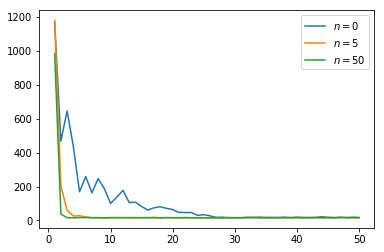

In [5]:
gamma = 0.95
alpha = 0.1
epsilon = 0.1

# %matplotlib inline
import matplotlib.pyplot as plt
for n in [0,5,50]:
    Q, StepCount = experiment(gamma,epsilon, alpha, n)
    plt.plot(range(1,51),StepCount, label = "$n=$" + str(n))
plt.legend(loc='upper right')
plt.show()

You may also find it interesting to see one of the learned policies in this case the last experiment with $n = 50$:

In [6]:
def printpolicy(Q):
    np.set_printoptions(threshold=np.nan)
    symbol = ['✪','⇧','⇩','⇦','⇨','☺','☹']
    n = 6
    m = 9
    I = np.zeros((n+2,m+2), dtype = int)
    I[1:n+1,1:m+1] = 1+np.argmax(Q[1:n+1,1:m+1,:], axis=2)
    I[2:5,3] = 0
    I[5,6] = 0
    I[1:4,8] = 0
    I[3,1] = 6
    I[1,9] = 5
    Grid = np.zeros((n+2,m+2), dtype = 'U1')
    for i in range(7): Grid[I == i] = symbol[i]
    print(Grid)

In [7]:
printpolicy(Q)

[['✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪']
 ['✪' '⇩' '⇧' '⇧' '⇧' '⇧' '⇧' '⇧' '✪' '☺' '✪']
 ['✪' '⇩' '⇩' '✪' '⇧' '⇧' '⇧' '⇧' '✪' '⇧' '✪']
 ['✪' '☹' '⇩' '✪' '⇨' '⇩' '⇧' '⇩' '✪' '⇧' '✪']
 ['✪' '⇨' '⇩' '✪' '⇨' '⇨' '⇨' '⇨' '⇨' '⇧' '✪']
 ['✪' '⇨' '⇨' '⇨' '⇧' '⇧' '✪' '⇧' '⇨' '⇧' '✪']
 ['✪' '⇧' '⇧' '⇨' '⇨' '⇧' '⇧' '⇧' '⇧' '⇧' '✪']
 ['✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪']]
